# Road Crash Webserver with Folium and Flask

## Introduction

This is an example of a webserver that serves maps showing locations of fatal road crashes in Queensland.

The packages used are:

- Flask, to provide webserver functions

- Folium, to provide mapping functions



## Implementation

### Imports and global directives

Note the ```pylint``` command (disguised as a comment).  This turns off a number of warnings, including constant variables that aren't all-caps. 

In [1]:
'''
    Example flask webserver using folium
'''
# pylint: disable=invalid-name, protected-access, global-statement
from flask import Flask
from flask import render_template
from flask import Markup
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

import pandas as pd

### Constants for server

```app``` is the webserver application; ```fatal``` is the placeholder for the fatal road crash dataframe.

In [2]:
app = Flask(__name__)


# will hold fatal crash data
fatal = None

### Supporting mapping functions

#### add_heat_map
```add_heat_map``` add a heatmap overlay to an existing Folium map.

In [3]:
def add_heat_map(folium_map: folium.Map) -> None:
    '''
    add_heat_map: add heat map for fatal crashes

    Parameters:
    folium_map: map to which heat map is to be added as Layer

    Return:
    None

    Side Effects:
    Adds heat map Layer to input map
    '''

    global fatal
    lat = list(fatal['Crash_Latitude_GDA94'])
    lng = list(fatal['Crash_Longitude_GDA94'])

    heat_in = [[y, x] for y, x in zip(lat, lng)]

    HeatMap(
        data=heat_in, name='Heat Map', show=False, control=True, min_opacity=0.5
    ).add_to(folium_map)


# end add_heat_map

#### add_markers

```add_markers``` adds markers corresponding to fatal road crashes to a Folium map.  The markers are defined to be a Feature Group, so they can turned on / off as desired by the map viewer.

In [4]:
def add_markers(folium_map: folium.Map) -> None:
    '''
    annotate_map: add fatal crash markers to map

    Parameters:
    folium_map: map to which markers are to be added as Layer

    Returns:
    None

    Side Effects:
    Adds markers to input map as a Layer

    '''
    global fatal
    lat = list(fatal['Crash_Latitude_GDA94'])
    lng = list(fatal['Crash_Longitude_GDA94'])
    dead_count = list(fatal['Count_Casualty_Fatality'])
    crash_nature = list(fatal['Crash_Nature'])
    crash_type = list(fatal['Crash_Type'])

    FATAL_MARKER_SIZE = 10
    FATAL_MARKER_FILL_OPACITY = 0.25

    # create a FeatureGroup so Crashes can be turned off
    fatal_fg = folium.FeatureGroup(name='Fatal Crashes', show=True)

    # for each fatal crash, add marker to layer
    # marker is translucent so zoom out will look ok

    for marker_y, marker_x, marker_dc, marker_cn, marker_ct in zip(
        lat, lng, dead_count, crash_nature, crash_type
    ):

        circ_mkr = folium.CircleMarker(
            location=[marker_y, marker_x],
            radius=FATAL_MARKER_SIZE,
            color='red',
            fill=True,
            fill_color='red',
            fillOpacity=FATAL_MARKER_FILL_OPACITY,
            opacity=FATAL_MARKER_FILL_OPACITY,\
            tooltip=f'{marker_dc} Dead',
            popup=marker_cn,
        )
        circ_mkr.add_to(fatal_fg)
    # end for

    # add unclustered markers to map
    fatal_fg.add_to(folium_map)

    return None


# end add_markers

#### add_clusters

```add_clusters``` will add clustered markers: when zoomed out, the map viewer will see a summary marker with a marker count inside.

In [5]:
def add_clusters(folium_map: folium.Map) -> None:
    '''
    annotate_map: add clustered fatal crash markers to map

    Parameters:
    folium_map: map to which markers are to be added as Layer

    Returns
    None

    Side Effects:
    Adds markers to input map as a Layer

    '''
    global fatal
    lat = list(fatal['Crash_Latitude_GDA94'])
    lng = list(fatal['Crash_Longitude_GDA94'])
    dead_count = list(fatal['Count_Casualty_Fatality'])
    crash_nature = list(fatal['Crash_Nature'])
    crash_type = list(fatal['Crash_Type'])

    FATAL_MARKER_SIZE = 10
    FATAL_MARKER_FILL_OPACITY = 0.25

    # create a marker cluster layer
    clusters = MarkerCluster(name='Clustered Markers', show=False, control=True)

    # for each fatal crash, add marker to layer
    # marker is translucent so zoom out will look ok

    for marker_y, marker_x, marker_dc, marker_cn, marker_ct in zip(
        lat, lng, dead_count, crash_nature, crash_type
    ):
        circ_mkr = folium.CircleMarker(
            location=[marker_y, marker_x],
            radius=FATAL_MARKER_SIZE,
            color='red',
            fill=True,
            fill_color='red',
            fillOpacity=FATAL_MARKER_FILL_OPACITY,
            opacity=FATAL_MARKER_FILL_OPACITY,
            tooltip=f'{marker_dc} Dead',
            popup=marker_cn,
        )

        circ_mkr.add_to(clusters)
    # end for

    # add clustered markers to map
    clusters.add_to(folium_map)

    return None


# end add_clusters

### Flask routing functions

The web app design is simple: 

- have a home page, with welcome and instructions

- have a map display page

Each page has the same structure:

- a top bar with Headline and menu options

- content

- a footer with copyright, etc.

####  Home Page

Render and serve home page.  ```index.html``` is a Flask template that expands a base template.

In [6]:
@app.route('/')
def index() -> str:
    '''
    index: returns home page of example server, with welcoming text
    '''
    return render_template(
        'index.html',
        map_div='',
        hdr_txt='',
        script_txt='',
        title='QLD Crash Map',
        folium_version=folium.__version__,
    )


# end index

#### Crash Map Page

Render and display a map.  This function uses the ability of Folium maps to be subdivided into:

- Header text, being styles, etc that must be invoked for Folium maps to be displayed correctly

- A Map div, being the definition of a HTML ```div``` to hold the map

- Footer text, being the scripts to actually draw the map into the previously defined map div.  These  * must * appear after the map div has been defined.

In [7]:
@app.route('/crashmap')
def crashmap() -> str:
    '''
    crashmap: generates a webpage holding a leaflet / folium map
    '''
    start_coords = (-26.52, 153.09)
    folium_map = folium.Map(
        tiles=None,
        location=start_coords,
        zoom_start=13,
        width='80%',
        height='80%',
        control_scale=True,
    )

    # support two basemaps
    folium.TileLayer(tiles='OpenStreetMap', name='Open Street Map', show=True).add_to(
        folium_map
    )
    folium.TileLayer(tiles='stamentoner', name='Black/White Map', show=False).add_to(
        folium_map
    )

    # add un-clustered markers layer
    add_markers(folium_map)

    # add the clustered fatal crash markers layer
    add_clusters(folium_map)

    # add heat map layer
    add_heat_map(folium_map)

    # add control to pick basemap, layers to show
    folium.LayerControl().add_to(folium_map)

    # Extract the components of the web map

    #
    #  The HTML to create a <div> and <iframe> to hold the map
    #
    #  The header text to get styles, scripts, etc
    #
    #  The scripts needed to run

    # first, force map to render as HTML, for us to dissect
    _ = folium_map._repr_html_()

    # get definition of map in body
    map_div = Markup(folium_map.get_root().html.render())

    # html to be included in header
    hdr_txt = Markup(folium_map.get_root().header.render())

    # html to be included in <script>
    script_txt = Markup(folium_map.get_root().script.render())

    return render_template(
        'crashmap.html',
        map_div=map_div,
        hdr_txt=hdr_txt,
        script_txt=script_txt,
        title='QLD Crash Map Annotated',
    )


# end crashmap

### Data Load

Load the Queensland Road Crash database.

In [8]:
def load_crash_data() -> pd.DataFrame:
    '''
    load_crash_data: load crash dataset into pandas DataFrame

    Parameters:
    None

    Returns:
    Pandas DataFrame

    Side Effects:
    updates global variable fatal with DataFrame contents
    '''
    global fatal
    crash_path = 'D:\\QLDCrashLocations\\data\\locations.csv'

    #  tell pandas that PostCodes are not integers, but strings
    crashes = pd.read_csv(crash_path, dtype={'Loc_Post_Code': str})
    fatal = crashes[crashes["Crash_Severity"] == 'Fatal']

    return fatal


# end load_crash

------
## Start the server

In [ ]:
if __name__ == '__main__':
    # load fatal crash data
    print('data loading ...')
    load_crash_data()
    print('data loaded')

    app.run()


data loading ...
data loaded
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [04/Dec/2019 15:43:31] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2019 15:43:31] "GET /static/css/main.css HTTP/1.1" 304 -
127.0.0.1 - - [04/Dec/2019 15:43:31] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [04/Dec/2019 15:45:17] "GET /crashmap HTTP/1.1" 200 -


---------

## Map Displays

### Default map

The image below shows the default map displayed

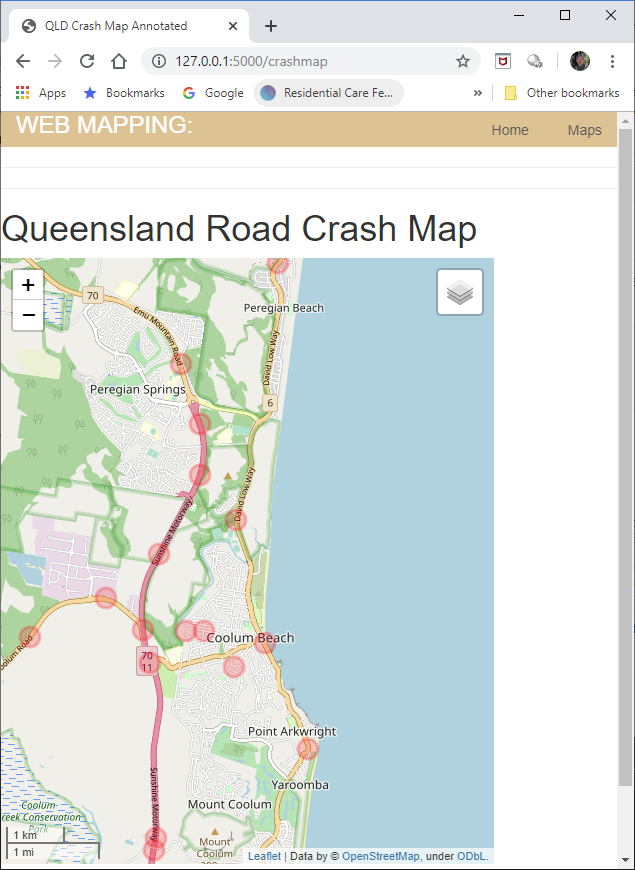

In [1]:
from IPython.display import Image
Image('images/crashmap01.png')

### Black background

The image belows shows the alternative black and white background.

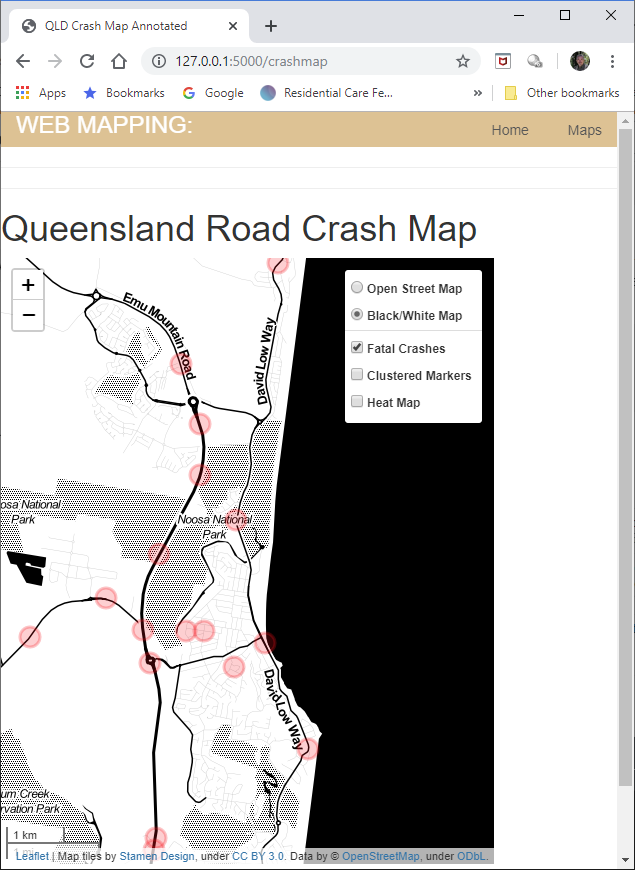

In [2]:
from IPython.display import Image
Image('images/crashmapblack.png')

### Drill down

The image below shows how the user can drill down on the details of a specific fatal accident.

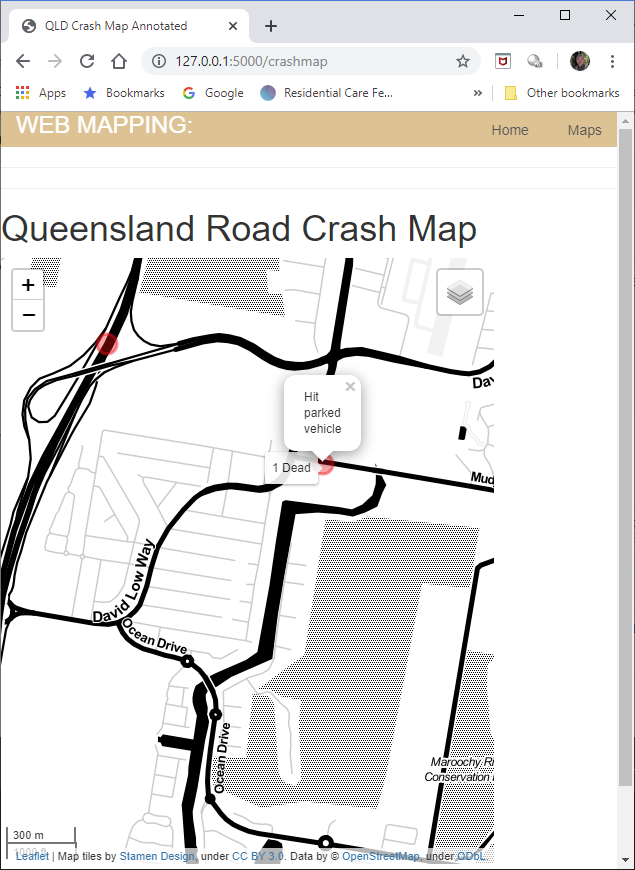

In [8]:
from IPython.display import Image
Image('images/crashmapdrilldown.png')

### Markers only

The image below shows the use of markers, when zoomed out.  You can see how lethal highways can be!

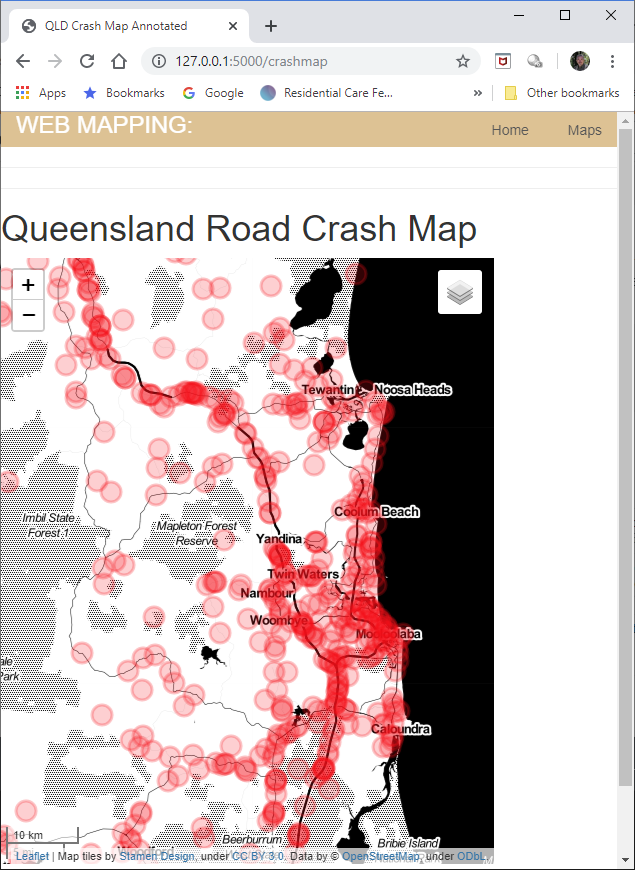

In [3]:
from IPython.display import Image
Image('images/crashmapmarkersonly.png')

### Summary Markers

The image below shows the use of summary markers.

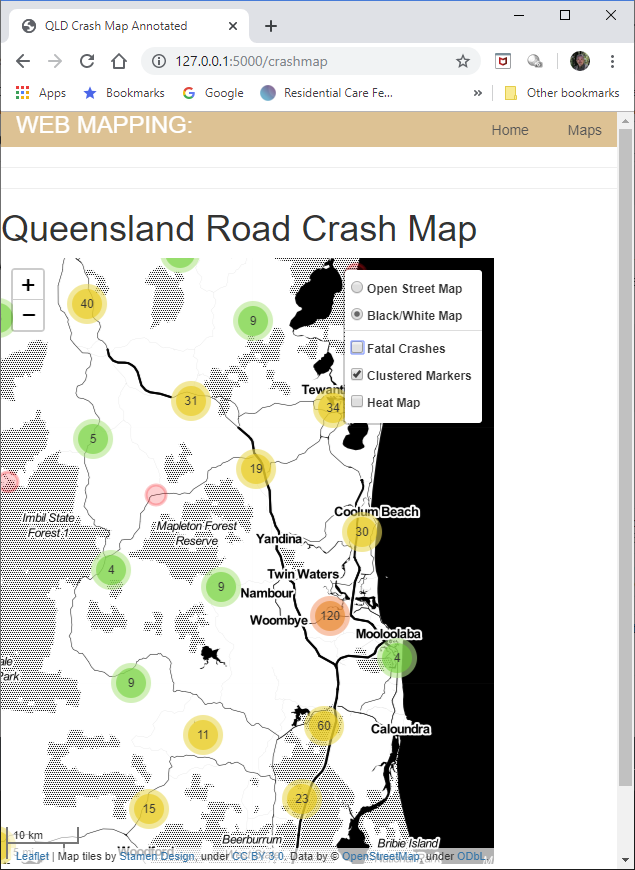

In [4]:
from IPython.display import Image
Image('images/crashmapsummary.png')

### Two layers

The image below shows how multiple layers can be visible at once.

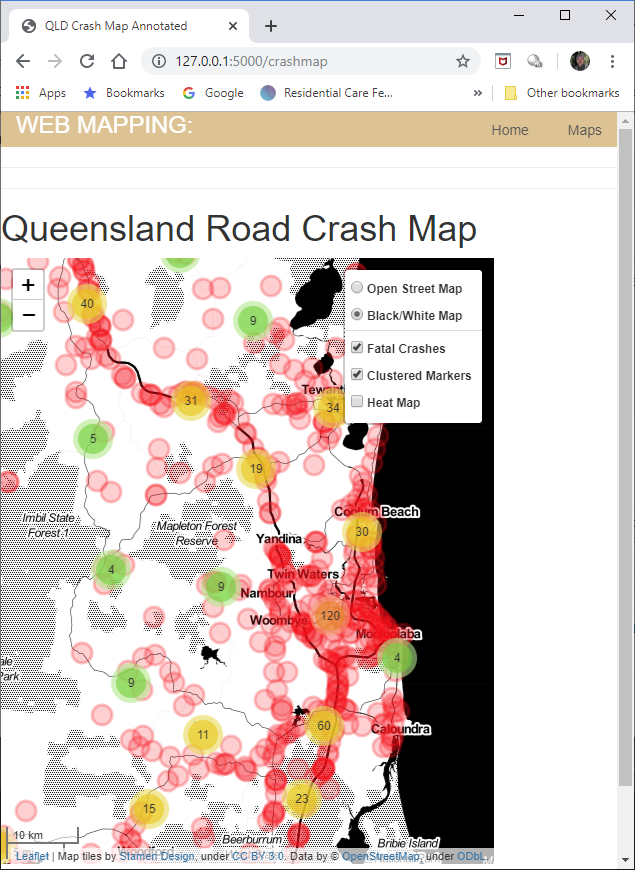

In [5]:
from IPython.display import Image
Image('images/crashmapboth.png')

### Heat Map

The image below show the heat map visualization.

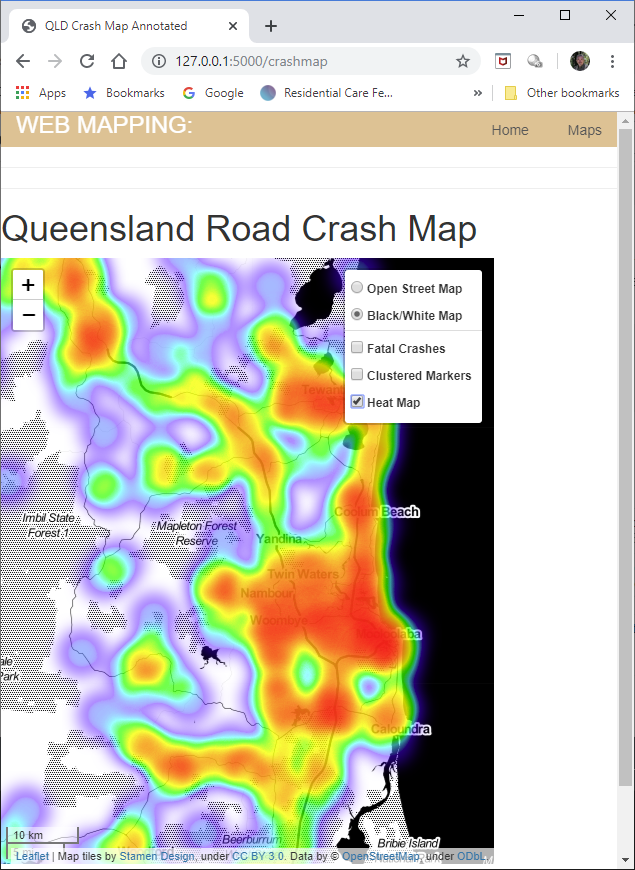

In [6]:
from IPython.display import Image
Image('images/crashmapheat.png')

### Home page

For completeness, the image below shows the home page.

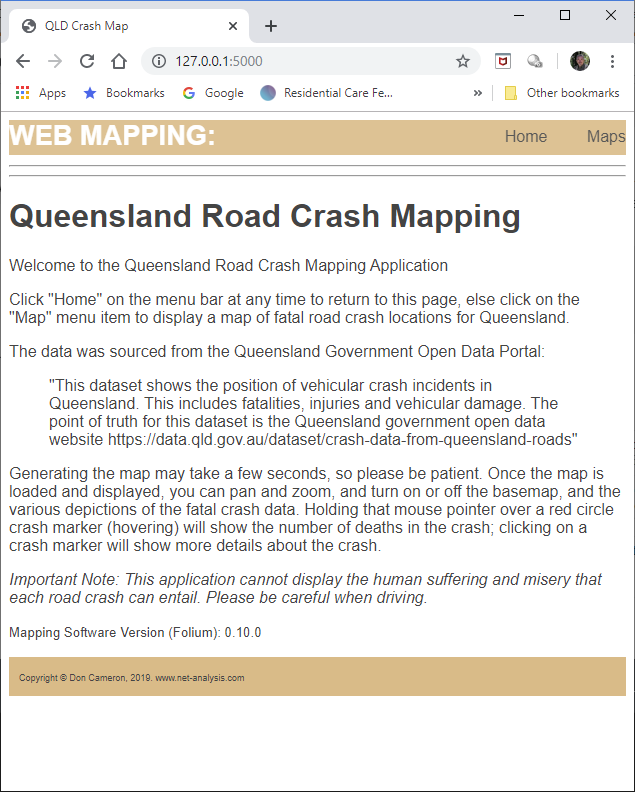

In [7]:
from IPython.display import Image
Image('images/homepage.png')

-------------
## Flask Templates

For completeness, all the templates used are shown below.

### Base template

The base template (```base.html```) is expanded / rendered by all pages

------------

```
<!DOCTYPE html>
<html>
    {#  Define base structure of app:                                   #}
    {#                                top-of-page menu,                 #}
    {#                                content (could be map)            #}
    {#                                footer with copyright notice      #}
    {# Parameters: expects title to be defined, falls back if not       #}
    {# #}
    {# Note: expects extending templates to define 'content' block #}
    {#       expects extending template rendering to define parameters:  #}
    {# 'hdr_txt', holding styles for leaflet #}
    {# 'script_txt', holding JS scripts for leaflet #}
        

    <head>
        <link rel="stylesheet" href="{{ url_for('static', filename='css/main.css') }}">
        {% if title %}
        <title>{{ title }} </title>
        {% else %}
        <title>Folium Example</title>
        {% endif %}
    
        {{ hdr_txt  }}
        
    </head>
    <body>
        <header>
            <div class="container">
                <h1 class="logo">Web Mapping:</h1>
                <ul class="menu">
                    <li><a href="{{ url_for('index') }}">Home</a></li>
                    <li><a href="{{ url_for('crashmap') }}">Maps</a></li>
                </ul>
            </div>
        </header>
        <hr/>
        {% block content %}
        {% endblock %}
    
        <div id="footer">
            <span class="tiny">
                Copyright © Don Cameron, 2019. www.net-analysis.com
            </span>
        </div>
    </body>  
    {# Note: script_txt MUST follow the body, so that div ids are defined to be referenced in the scripts #}
    <script>
        {{ script_txt }}
    </script>
</html>
```
-------------

####  Home page 

Below is the ```index.html``` template.

------------


```
{# Define home / index page for app #}
{% extends 'base.html' %}

{% block content %}
    <hr/>
    <h1> Queensland Road Crash Mapping </h1>
    <p>Welcome to the Queensland Road Crash Mapping Application</p>
    <p>Click "Home" on the menu bar at any time to return to this page, else click 
        on the "Map" menu item to display a map of fatal road crash locations for Queensland. 
    </p>
    <p>The data was sourced from the Queensland Government Open Data Portal:  </p>
        <blockquote>
        "This dataset shows the position of vehicular crash incidents in Queensland. 
        This includes fatalities, injuries and vehicular damage. 
        The point of truth for this dataset is the Queensland government open data website 
        https://data.qld.gov.au/dataset/crash-data-from-queensland-roads"
        </blockquote>

    <p>Generating the map may take a few seconds, so please be patient.  
        Once the map is loaded and displayed, you can pan and zoom,
        and turn on or off the basemap, and the various depictions of the fatal crash data.  
        Holding that mouse pointer over a red circle crash marker (hovering) will show the number of deaths in the crash; 
        clicking on a crash marker will show more details about the crash.
    </p>  
    <p><em>Important Note:  This application cannot display the human suffering and misery that each road crash can entail.
        Please be careful when driving.</em></p>

    <p><small>Mapping Software Version (Folium): {{ folium_version }}</small></p>
{% endblock %}
```
---------------

#### Map display page

Below is the ```crashmap.html``` template

------------

```
{# define content block holding folium / leaflet map #}
{# expects renderers to define a parameter 'map_div' #}

{% extends 'base.html' %}

{% block content %}
<hr/>

<h1> Queensland Road Crash Map </h1>
{#  Map goes here                                  #}
{{ map_div }}
<hr/>
{% endblock %}
```
-------------
